In [2]:
import pandas as pd
import numpy as np
import networkx as nx

import itertools
from copy import deepcopy

import matplotlib.pyplot as plt

## Pre-processing objects data

In [3]:
class Obj:
    def __init__(self, raw):
        self.id = int(raw['id_obj'].iloc[0])
        self.obj_sea = bool(raw['Obj_Sea'].iloc[0])
        self.obj_air = bool(raw['Obj_Air'].iloc[0])
        self.obj_land = bool(raw['Obj_Land'].iloc[0])
        self.location_poly = raw[['Location_Poly_X', 'Location_Poly_Y']].dropna().values.tolist()
        self.location_point = raw[['Location_Point_X', 'Location_Point_Y']].dropna().values.tolist()
        self.density = float(raw['Density'].iloc[0])
        self.wind_speed = float(raw['WindSpeed'].iloc[0])
        self.wind_dir = float(raw['WindDirectionDegree'].iloc[0])

In [4]:
num_obj1 = (sum(1 for _ in open('../data/M3/LikeMineSweep/Obj_1.csv')) - 1) // 11
obj1_raw = [pd.read_csv('../data/M3/LikeMineSweep/Obj_1.csv', skiprows=i * 11 + 1, nrows=11, index_col=0, header=None).T for i in range(num_obj1)]
obj1 = [Obj(o) for o in obj1_raw]

num_obj2 = (sum(1 for _ in open('../data/M3/LikeMineSweep/Obj_2.csv')) - 1) // 11
obj2_raw = [pd.read_csv('../data/M3/LikeMineSweep/Obj_2.csv', skiprows=i * 11 + 1, nrows=11, index_col=0, header=None).T for i in range(num_obj2)]
obj2 = [Obj(o) for o in obj2_raw]

num_obj3 = (sum(1 for _ in open('../data/M3/LikeMineSweep/Obj_3.csv')) - 1) // 11
obj3_raw = [pd.read_csv('../data/M3/LikeMineSweep/Obj_3.csv', skiprows=i * 11 + 1, nrows=11, index_col=0, header=None).T for i in range(num_obj3)]
obj3 = [Obj(o) for o in obj3_raw]

num_obj4 = (sum(1 for _ in open('../data/M3/LikeMineSweep/Obj_4.csv')) - 1) // 11
obj4_raw = [pd.read_csv('../data/M3/LikeMineSweep/Obj_4.csv', skiprows=i * 11 + 1, nrows=11, index_col=0, header=None).T for i in range(num_obj4)]
obj4 = [Obj(o) for o in obj4_raw]

obj1[0].__dict__

{'id': 1,
 'obj_sea': True,
 'obj_air': True,
 'obj_land': True,
 'location_poly': [[15.7434402332362, 88.7755102040816],
  [10.2040816326531, 68.3673469387755],
  [31.1953352769679, 49.4169096209912],
  [43.4402332361516, 83.5276967930029]],
 'location_point': [[13.3663592928214, 68.3905755820015],
  [13.3663592928214, 71.5528532421699],
  [13.3663592928214, 74.7151309023383],
  [13.3663592928214, 77.8774085625066],
  [16.5286369529898, 65.2282979218331],
  [16.5286369529898, 68.3905755820015],
  [16.5286369529898, 71.5528532421699],
  [16.5286369529898, 74.7151309023383],
  [16.5286369529898, 77.8774085625066],
  [16.5286369529898, 81.039686222675],
  [16.5286369529898, 84.2019638828434],
  [16.5286369529898, 87.3642415430118],
  [19.6909146131582, 62.0660202616648],
  [19.6909146131582, 65.2282979218331],
  [19.6909146131582, 68.3905755820015],
  [19.6909146131582, 71.5528532421699],
  [19.6909146131582, 74.7151309023383],
  [19.6909146131582, 77.8774085625066],
  [19.6909146131582,

## Pre-processing agents data

In [5]:
class Agent:
    def __init__(self, raw):
        self.id = int(raw[0])
        self.type = int(raw[1])
        self.base = int(raw[2])
        self.gear1 = bool(raw[3])
        self.gear2 = bool(raw[4])
        self.gear3 = bool(raw[5])
        self.gear4 = bool(raw[6])
        self.location = [float(raw[7]), float(raw[8])]
        self.speed = float(raw[9])
        self.energy_consumption = float(raw[10])
        self.remain_energy = float(raw[11])
        self.mine_check_prob = float(raw[12])

In [6]:
agents_raw = pd.read_csv('../data/M3/LikeMineSweep/Agent.csv').values.tolist()
num_agents = len(agents_raw)
agents = [Agent(agents_raw[i]) for i in range(num_agents)]

agents[0].__dict__

{'id': 1,
 'type': 1,
 'base': 1,
 'gear1': True,
 'gear2': True,
 'gear3': False,
 'gear4': False,
 'location': [20.0, 30.0],
 'speed': 3.0,
 'energy_consumption': 2.0,
 'remain_energy': 100.0,
 'mine_check_prob': 0.7}

## Pre-processing base data

In [7]:
class Base:
    def __init__(self, raw):
        self.id = int(raw[0])
        self.location = [float(raw[1]), float(raw[2])]
        self.is_sea = bool(raw[3])
        self.is_air = bool(raw[4])
        self.is_land = bool(raw[5])

In [8]:
bases_raw = pd.read_csv('../data/M3/LikeMineSweep/Base.csv').values.tolist()
num_bases = len(bases_raw)
bases = [Base(bases_raw[i]) for i in range(num_bases)]

bases[0].__dict__

{'id': 1,
 'location': [20.0, 30.0],
 'is_sea': False,
 'is_air': True,
 'is_land': True}

## Generating objects network

In [9]:
obj1_graph = nx.Graph()

obj1_combined_location = []
obj1_point_group = []
for i, obj in enumerate(obj1):
    obj1_combined_location.extend(obj.location_point)
    obj1_point_group.extend([i for _ in range(len(obj.location_point))])

print(obj1_point_group)

for (i, point_i), (j, point_j) in itertools.combinations(enumerate(obj1_combined_location), 2):

    dist = abs(point_i[0] - point_j[0]) + abs(point_i[1] - point_j[1])
    # print(i, j, dist)
    if 3 < dist < 3.5:
        obj1_graph.add_edge(i, j, cost=dist)

num_nodes = max(obj1_graph.nodes) + 1

obj1_outer = [node for node in obj1_graph.nodes() if obj1_graph.degree[node] < 4]
for i in obj1_outer:
    min_dist = 1e10
    min_neighbor = None
    for j in obj1_outer:
        if i == j:
            continue
        if obj1_point_group[i] == obj1_point_group[j]:
            continue

        point_i = obj1_combined_location[i]
        point_j = obj1_combined_location[j]
        dist = abs(point_i[0] - point_j[0]) + abs(point_i[1] - point_j[1])

        if dist < min_dist:
            min_dist = dist
            min_neighbor = j
    if not obj1_graph.has_edge(i, min_neighbor):
        obj1_graph.add_edge(i, min_neighbor)
    for j, base in enumerate(bases):
        obj1_graph.add_edge(i, num_nodes + j)

for base in bases:
    obj1_combined_location.append(base.location)

print(len(obj1_graph.nodes))
print(len(obj1_combined_location))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
153
153


## Visualizing the map

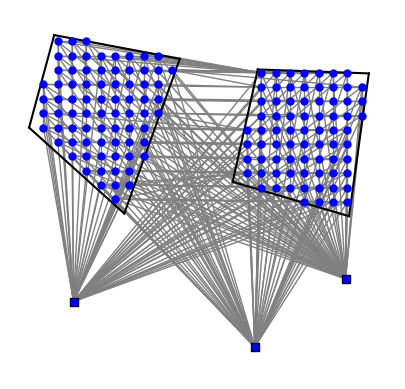

In [10]:
fig, ax = plt.subplots(1)
ax.set_aspect('equal', 'box')
for obj in obj1:
    num_poly = len(obj.location_poly)
    for i in range(num_poly):
        point_1 = obj.location_poly[i]
        point_2 = obj.location_poly[(i+1) % num_poly]
        ax.plot([point_1[0], point_2[0]], [point_1[1], point_2[1]], 'k-')
#
#     num_points = len(obj.location_point)
#     for i in range(num_points):
#         point = obj.location_point[i]
#         ax.plot(point[0], point[1], marker='.', color='b')

# for obj in obj2:
#     num_points = len(obj.location_point)
#     for i in range(num_points):
#         point = obj.location_point[i]
#         ax.plot(point[0], point[1], marker='o', color='m')

# for obj in obj3:
#     num_points = len(obj.location_point)
#     for i in range(num_points):
#         point = obj.location_point[i]
#         ax.plot(point[0], point[1], marker='o', color='g')

# for obj in obj4:
#     num_points = len(obj.location_point)
#     for i in range(num_points):
#         point = obj.location_point[i]
#         ax.plot(point[0], point[1], marker='o', color='r')

for base in bases:
    ax.plot(base.location[0], base.location[1], marker='s', color='k')


nx.draw(obj1_graph, ax=ax, pos=obj1_combined_location, node_shape='.', node_size=100, edge_color='gray', node_color='b')

plt.show()

In [11]:
from functools import reduce
import operator

def getFromDict(dataDict, mapList):
    return reduce(operator.getitem, mapList, dataDict)

def setInDict(dataDict, mapList, value):
    getFromDict(dataDict, mapList[:-1])[mapList[-1]] = value

class Sharing:
    MIN = 0
    MAX = 1
    AVG = 2
    CNT = 3
    def __init__(self):
        self.data = dict()
        self.type = dict()
        self.alpha = dict()

    def __getitem__(self, key):
        return self.data[key]

    def __setitem__(self, key, value):
        if not key in self.data:
            print('Key %s does not exist' % str(key))
            raise

        self.data[key] = deepcopy(value)

    def __delitem__(self, key):
        del self.data[key]
        del self.type[key]

    def add(self, key, data_type, alpha=0.5, data_init=None):
        ## TYPE
        # 0: Max consensus
        # 1: Min consensus
        # 2: Average consensus
        # 3: Count consensus
        self.data[key] = deepcopy(data_init)
        self.type[key] = data_type
        self.alpha[key] = alpha
        pass

    def update(self, other):
        for key in self.data.keys():
            if isinstance(other.data[key], dict):

                obj_list = [other.data[key]]
                key_list = [list(other.data[key].keys())]
                curr_key = [-1]
                while obj_list:
                    if not key_list[-1]:
                        i = len(curr_key)-1
                        while i >= 0 and not key_list[i]:
                            # print('aaa')
                            del obj_list[i]
                            del key_list[i]
                            del curr_key[i]
                            i -= 1
                        if i < 0:
                            break

                    curr_key[-1] = key_list[-1].pop(0)
                    curr_obj = obj_list[-1][curr_key[-1]]
                    # print(curr_key)
                    if isinstance(curr_obj, dict):
                        if not curr_key[-1] in getFromDict(self.data[key], curr_key[:-1]):
                            setInDict(self.data[key], curr_key, curr_obj)
                            # print('Skip')
                            continue
                        obj_list.append(curr_obj)
                        key_list.append(list(curr_obj.keys()))
                        curr_key.append(-1)
                    else:
                        if not curr_key[-1] in getFromDict(self.data[key], curr_key[:-1]):
                            setInDict(self.data[key], curr_key, curr_obj)

                        self_data = getFromDict(self.data[key], curr_key)

                        if self.type[key] == self.MIN:
                            setInDict(self.data[key], curr_key, min(self_data, curr_obj))
                        elif self.type[key] == self.MAX:
                            setInDict(self.data[key], curr_key, max(self_data, curr_obj))
                        elif self.type[key] == self.AVG:
                            setInDict(self.data[key], curr_key, 1. * self.alpha[key] * self_data + (1. - self.alpha[key]) * curr_obj)



In [45]:
Data1 = {i: {j:0.5 for j in range(len(obj1[i].location_point))} for i in range(len(obj1))}
Data2 = {i: {j:0 for j in range(len(obj1[i].location_point))} for i in range(len(obj1))}
Data3 = {i: {j:1 for j in range(len(obj1[i].location_point))} for i in range(len(obj1))}

for agent in agents:
    agent.data = Sharing()
    agent.data.add('data1', Sharing.MIN)
    agent.data.add('data2', Sharing.MAX)
    agent.data.add('data3', Sharing.AVG, 0.7)

agents[0].data['data1'] = Data1
agents[1].data['data1'] = Data2
agents[2].data['data1'] = Data3

agents[0].data['data2'] = Data1
agents[1].data['data2'] = Data2
agents[2].data['data2'] = Data3

agents[0].data['data3'] = Data1
agents[1].data['data3'] = Data2
agents[2].data['data3'] = Data3

for i in range(100):
    agents[0].data.update(agents[1].data)
    agents[0].data.update(agents[2].data)
    agents[1].data.update(agents[0].data)
    agents[1].data.update(agents[2].data)
    agents[2].data.update(agents[0].data)
    agents[2].data.update(agents[1].data)

In [46]:
print(agents[0].data['data1'])

{0: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0, 68: 0, 69: 0, 70: 0, 71: 0, 72: 0, 73: 0, 74: 0, 75: 0}, 1: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0, 68

In [47]:
print(agents[0].data['data2'])

{0: {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1, 47: 1, 48: 1, 49: 1, 50: 1, 51: 1, 52: 1, 53: 1, 54: 1, 55: 1, 56: 1, 57: 1, 58: 1, 59: 1, 60: 1, 61: 1, 62: 1, 63: 1, 64: 1, 65: 1, 66: 1, 67: 1, 68: 1, 69: 1, 70: 1, 71: 1, 72: 1, 73: 1, 74: 1, 75: 1}, 1: {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1, 47: 1, 48: 1, 49: 1, 50: 1, 51: 1, 52: 1, 53: 1, 54: 1, 55: 1, 56: 1, 57: 1, 58: 1, 59: 1, 60: 1, 61: 1, 62: 1, 63: 1, 64: 1, 65: 1, 66: 1, 67: 1, 68

In [48]:
print(agents[1].data['data3'])

{0: {0: 0.5969537749421414, 1: 0.5969537749421414, 2: 0.5969537749421414, 3: 0.5969537749421414, 4: 0.5969537749421414, 5: 0.5969537749421414, 6: 0.5969537749421414, 7: 0.5969537749421414, 8: 0.5969537749421414, 9: 0.5969537749421414, 10: 0.5969537749421414, 11: 0.5969537749421414, 12: 0.5969537749421414, 13: 0.5969537749421414, 14: 0.5969537749421414, 15: 0.5969537749421414, 16: 0.5969537749421414, 17: 0.5969537749421414, 18: 0.5969537749421414, 19: 0.5969537749421414, 20: 0.5969537749421414, 21: 0.5969537749421414, 22: 0.5969537749421414, 23: 0.5969537749421414, 24: 0.5969537749421414, 25: 0.5969537749421414, 26: 0.5969537749421414, 27: 0.5969537749421414, 28: 0.5969537749421414, 29: 0.5969537749421414, 30: 0.5969537749421414, 31: 0.5969537749421414, 32: 0.5969537749421414, 33: 0.5969537749421414, 34: 0.5969537749421414, 35: 0.5969537749421414, 36: 0.5969537749421414, 37: 0.5969537749421414, 38: 0.5969537749421414, 39: 0.5969537749421414, 40: 0.5969537749421414, 41: 0.596953774942141

In [15]:
from functools import reduce
import operator

def getFromDict(dataDict, mapList):
    return reduce(operator.getitem, mapList, dataDict)

def setInDict(dataDict, mapList, value):
    getFromDict(dataDict, mapList[:-1])[mapList[-1]] = value

class Sharing:
    MIN = 0
    MAX = 1
    AVG = 2
    CNT = 3
    def __init__(self):
        self.data = dict()
        self.type = dict()
        self.alpha = dict()

    def __getitem__(self, key):
        return self.data[key]

    def __setitem__(self, key, value):
        if not key in self.data:
            print('Key %s does not exist' % str(key))
            raise

        self.data[key] = deepcopy(value)

    def __delitem__(self, key):
        del self.data[key]
        del self.type[key]

    def add(self, key, data_type, alpha=0.5, data_init=None):
        ## TYPE
        # 0: Max consensus
        # 1: Min consensus
        # 2: Average consensus
        # 3: Count consensus
        self.data[key] = deepcopy(data_init)
        self.type[key] = data_type
        self.alpha[key] = alpha
        pass

    def update(self, other):
        for key in self.data.keys():
            if isinstance(other.data[key], dict):

                obj_list = [other.data[key]]
                key_list = [list(other.data[key].keys())]
                curr_key = [-1]
                while obj_list:
                    if not key_list[-1]:
                        i = len(curr_key)-1
                        while i >= 0 and not key_list[i]:
                            # print('aaa')
                            del obj_list[i]
                            del key_list[i]
                            del curr_key[i]
                            i -= 1
                        if i < 0:
                            break

                    curr_key[-1] = key_list[-1].pop(0)
                    curr_obj = obj_list[-1][curr_key[-1]]
                    # print(curr_key)
                    if isinstance(curr_obj, dict):
                        if not curr_key[-1] in getFromDict(self.data[key], curr_key[:-1]):
                            setInDict(self.data[key], curr_key, curr_obj)
                            # print('Skip')
                            continue
                        obj_list.append(curr_obj)
                        key_list.append(list(curr_obj.keys()))
                        curr_key.append(-1)
                    else:
                        if not curr_key[-1] in getFromDict(self.data[key], curr_key[:-1]):
                            setInDict(self.data[key], curr_key, curr_obj)

                        self_data = getFromDict(self.data[key], curr_key)

                        if self.type[key] == self.MIN:
                            setInDict(self.data[key], curr_key, min(self_data, curr_obj))
                        elif self.type[key] == self.MAX:
                            setInDict(self.data[key], curr_key, max(self_data, curr_obj))
                        elif self.type[key] == self.AVG:
                            setInDict(self.data[key], curr_key, 1. * self.alpha[key] * self_data + 1. * (1-self.alpha[key]) * curr_obj)



In [510]:
Data1 = {i: {j:np.random.randint(0, 2) for j in range(len(obj1[i].location_point))} for i in range(len(obj1))}
Data2 = {i: {j:0 for j in range(len(obj1[i].location_point))} for i in range(len(obj1))}
Data3 = {i: {j:1 for j in range(len(obj1[i].location_point))} for i in range(len(obj1))}

for agent in agents:
    agent.data = Sharing()
    agent.data.add('data1', Sharing.MIN)
    agent.data.add('data2', Sharing.MAX)
    agent.data.add('data3', Sharing.AVG, 0.7)

agents[0].data['data1'] = Data1
agents[1].data['data1'] = Data2
agents[2].data['data1'] = Data3

agents[0].data['data2'] = Data1
agents[1].data['data2'] = Data2
agents[2].data['data2'] = Data3

agents[0].data['data3'] = Data1
agents[1].data['data3'] = Data2
agents[2].data['data3'] = Data3

agents[0].data.update(agents[1].data)
agents[0].data.update(agents[2].data)

In [511]:
print(agents[0].data['data1'])

{0: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0, 68: 0, 69: 0, 70: 0, 71: 0, 72: 0, 73: 0, 74: 0, 75: 0}, 1: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0, 68

In [512]:
print(agents[0].data['data2'])

{0: {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1, 47: 1, 48: 1, 49: 1, 50: 1, 51: 1, 52: 1, 53: 1, 54: 1, 55: 1, 56: 1, 57: 1, 58: 1, 59: 1, 60: 1, 61: 1, 62: 1, 63: 1, 64: 1, 65: 1, 66: 1, 67: 1, 68: 1, 69: 1, 70: 1, 71: 1, 72: 1, 73: 1, 74: 1, 75: 1}, 1: {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1, 47: 1, 48: 1, 49: 1, 50: 1, 51: 1, 52: 1, 53: 1, 54: 1, 55: 1, 56: 1, 57: 1, 58: 1, 59: 1, 60: 1, 61: 1, 62: 1, 63: 1, 64: 1, 65: 1, 66: 1, 67: 1, 68

In [513]:
print(agents[0].data['data3'])

{0: {0: 0.79, 1: 0.30000000000000004, 2: 0.30000000000000004, 3: 0.30000000000000004, 4: 0.79, 5: 0.79, 6: 0.79, 7: 0.79, 8: 0.30000000000000004, 9: 0.30000000000000004, 10: 0.30000000000000004, 11: 0.30000000000000004, 12: 0.30000000000000004, 13: 0.30000000000000004, 14: 0.30000000000000004, 15: 0.30000000000000004, 16: 0.30000000000000004, 17: 0.30000000000000004, 18: 0.30000000000000004, 19: 0.30000000000000004, 20: 0.79, 21: 0.79, 22: 0.30000000000000004, 23: 0.79, 24: 0.30000000000000004, 25: 0.30000000000000004, 26: 0.79, 27: 0.79, 28: 0.30000000000000004, 29: 0.30000000000000004, 30: 0.79, 31: 0.30000000000000004, 32: 0.79, 33: 0.79, 34: 0.79, 35: 0.79, 36: 0.30000000000000004, 37: 0.30000000000000004, 38: 0.79, 39: 0.30000000000000004, 40: 0.79, 41: 0.30000000000000004, 42: 0.30000000000000004, 43: 0.79, 44: 0.30000000000000004, 45: 0.30000000000000004, 46: 0.79, 47: 0.30000000000000004, 48: 0.79, 49: 0.30000000000000004, 50: 0.79, 51: 0.30000000000000004, 52: 0.30000000000000